In [1]:
import sys
#sys.path.insert(0, '/home/jovyan/work/Molecular_Properties/model-pipeline/src')
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from model_construction import prepare_data_split, run_model, show_varimp
from bearinmind_pipeline.data_preprocessing import dataPreprocessing as dp
#from bearinmind_pipeline.model_construction import modelBuilder as mb
import bearinmind_pipeline.model_construction as mc
from numpy import inf
from sklearn.metrics import mean_squared_error
from math import sqrt
import gc
from tqdm import tqdm_notebook, tqdm 
import matplotlib.pyplot as plt
import datetime
import json
from scipy import stats
import holidays
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [199]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
mapping = pd.read_csv('./data/building_metadata.csv')

In [200]:
weather_train = pd.read_csv('./data/weather_train.csv')
weather_test = pd.read_csv('./data/weather_test.csv')

In [201]:
### Add Holidays ###
def get_holidays(df):
    en_holidays = holidays.England()
    ir_holidays = holidays.Ireland()
    ca_holidays = holidays.Canada()
    us_holidays = holidays.UnitedStates()
    en_idx = df.query('site_id == 1 or site_id == 5').index
    ir_idx = df.query('site_id == 12').index
    ca_idx = df.query('site_id == 7 or site_id == 11').index
    us_idx = df.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index
    df['IsHoliday'] = 0
    df.loc[en_idx, 'IsHoliday'] = df.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df.loc[ir_idx, 'IsHoliday'] = df.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df.loc[ca_idx, 'IsHoliday'] = df.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df.loc[us_idx, 'IsHoliday'] = df.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))
    holiday_idx = df['IsHoliday'] != 0
    df.loc[holiday_idx, 'IsHoliday'] = 1
    df['IsHoliday'] = df['IsHoliday'].astype(np.uint8)
    
    return df

In [202]:
weather_train = get_holidays(weather_train)
weather_test = get_holidays(weather_test)

In [203]:
timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
weather_train['timediff']= weather_train['site_id'].map(timediff)
weather_test['timediff']= weather_test['site_id'].map(timediff)

weather_train['timediff'] = weather_train['timediff'].apply(lambda x: datetime.timedelta(hours=x))
weather_test['timediff'] = weather_test['timediff'].apply(lambda x: datetime.timedelta(hours=x))

weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

weather_train['timestamp'] = weather_train['timestamp'] - weather_train['timediff']
weather_test['timestamp'] = weather_test['timestamp'] - weather_test['timediff']

In [204]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,timediff
0,0,2015-12-31 20:00:00,25.000,6.000,20.000,nan,1019.700,0.000,0.000,1,04:00:00
1,0,2015-12-31 21:00:00,24.400,nan,21.100,-1.000,1020.200,70.000,1.500,1,04:00:00
2,0,2015-12-31 22:00:00,22.800,2.000,21.100,0.000,1020.200,0.000,0.000,1,04:00:00
3,0,2015-12-31 23:00:00,21.100,2.000,20.600,0.000,1020.100,0.000,0.000,1,04:00:00
4,0,2016-01-01 00:00:00,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1,04:00:00


In [205]:
df_train = df_train.merge(mapping, how = "left", on = "building_id")
df_test = df_test.merge(mapping, how = "left", on = "building_id")

In [207]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

In [208]:
df_train = df_train.merge(weather_train, how = "left", on = ["site_id", "timestamp"])
df_test = df_test.merge(weather_test, how = "left", on =  ["site_id", "timestamp"])

In [157]:
del weather_train 
del weather_test

In [211]:
df_train = df_train.drop(['timediff'], axis = 1)
df_test = df_test.drop(['timediff'], axis = 1)

In [476]:
def rmsle(y, yhat):
    score = np.sqrt(np.mean(np.power(np.log(yhat+1)-np.log(y.reset_index(drop=True)+1), 2)))
    return(score)

In [123]:
# Check one building
df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [214]:
### Intrapolate cloud coverage
df_train['cloud_coverage'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1,limit_direction = "both", limit = 1000))
df_test['cloud_coverage'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both", limit = 1000))

In [ ]:
### Intrapolate air temperature
df_train['air_temperature'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))
df_test['air_temperature'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))

In [ ]:
df_train.head()

In [ ]:
#### Take a Sample ####
#df_train = df_train.sample(n=int(df_train.shape[0]*0.1), random_state=1)
#df_test = df_test.sample(n=int(df_test.shape[0]*0.1), random_state=1)

In [ ]:
#df_train["Month"] = pd.to_datetime(df_train["timestamp"]).dt.month
#df_test["Month"] = pd.to_datetime(df_test["timestamp"]).dt.month

In [ ]:
df_train["Day"] = pd.to_datetime(df_train["timestamp"]).dt.day
df_test["Day"] = pd.to_datetime(df_test["timestamp"]).dt.day

In [ ]:
df_train["Hour"] = pd.to_datetime(df_train["timestamp"]).dt.hour
df_test["Hour"] = pd.to_datetime(df_test["timestamp"]).dt.hour

In [ ]:
#df_train.to_csv("df_train.csv", index = False)
#df_test.to_csv("df_test.csv", index = False)

In [ ]:
#df_train = pd.read_csv('./df_train.csv')
#df_test = pd.read_csv('./df_test.csv')

In [ ]:
plt.plot(pd.to_datetime(df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['timestamp']).dt.date, df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['precip_depth_1_hr'])

In [ ]:
df_train['precip_depth_1_hr'] = df_train.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['precip_depth_1_hr'] = df_test.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['sea_level_pressure'] = df_train.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['sea_level_pressure'] = df_test.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['wind_direction'] = df_train.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_direction'] = df_test.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['wind_speed'] = df_train.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_speed'] = df_test.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['dew_temperature'] = df_train.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['dew_temperature'] = df_test.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train["DayOfWeek"] = pd.to_datetime(df_train["timestamp"]).dt.dayofweek
df_test["DayOfWeek"] = pd.to_datetime(df_test["timestamp"]).dt.dayofweek

In [ ]:
df_train.head()

In [ ]:
#df_train = dp.create_stats_features(df_train, 'dew_temperature', ['site_id', 'Month'])
#df_test = dp.create_stats_features(df_test, 'dew_temperature', ['site_id', 'Month'])

In [ ]:
#df_train["air_temperature_log"] = np.log(df_train['air_temperature'])
#df_test["air_temperature_log"] = np.log(df_test['air_temperature'])

In [ ]:
#df_train["Age"] = pd.to_datetime(df_train["timestamp"]).dt.year - df_train["year_built"]
#df_test["Age"] = pd.to_datetime(df_test["timestamp"]).dt.year - df_test["year_built"]

In [ ]:
### Clean Electricity ###
df_train = df_train[~((df_train['site_id'] == 0) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-20 18:00:00')))]

In [ ]:
df_train = df_train[~((df_train['building_id'] == 799) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-01 12:00:00')))]
df_train = df_train[~((df_train['building_id'] == 802) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-23 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 803) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')))]

In [237]:
df_train.to_csv("df_train.csv.gz", index = False, compression = 'gzip')
df_test.to_csv("df_test.csv.gz", index = False, compression = 'gzip')

In [2]:
df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [399]:
### Lags for cloud coverage and air temperature
#for i in range(12):
#    df_train[f'cloud_coverage_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_test[f'cloud_coverage_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_train[f'air_temperature_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)
#    df_test[f'air_temperature_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)

In [3]:
### Drop zero values in Electricity ###
df_train = df_train.drop(df_train[(df_train['meter'] == 0) 
                       & (df_train['meter_reading'] == 0.0)].index)

In [26]:
def create_add_features(df):
    df['relative_humidity'] = 100-5*(df['air_temperature'] - df['dew_temperature'])
    df['air_density_dry'] = df['sea_level_pressure']/(287.058 * df['air_temperature'])
    df['vapor_pressure_water_satur'] = 6.102*10**((7.5*df['air_temperature'])/(df['air_temperature']+237.8))
    df['vapor_pressure_water'] =  df['relative_humidity']*df['vapor_pressure_water_satur']
    df['partial_press_dry'] = df['sea_level_pressure']-df['vapor_pressure_water'] 
    df['air_density_humid'] = (df['partial_press_dry']*0.0289654+df['vapor_pressure_water'] *0.018016)/8.314*df['air_temperature']
    
    return df

In [5]:
df_train = create_add_features(df_train)

In [6]:
df_train = df_train[~((df_train['building_id'] == 106) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-01 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 112) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-01 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 144) & (df_train['meter'] == 0) & 
                      (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-08 13:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-11 16:00:00')))]
df_train = df_train[~((df_train['building_id'] == 107) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-06 12:00:00')) | 
                     (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-11-10 02:00:00'))))]

In [7]:
df_train = df_train[~((df_train['building_id'] == 740) & (df_train['meter'] == 0))] 

In [8]:
df_train = df_train[~((df_train['building_id'] == 1241) & (df_train['meter'] == 3) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-22 14:00:00')))]

In [9]:
df_train = df_train[~((df_train['building_id'] == 60) & (df_train['meter'] == 1) & (df_train['meter_reading'] > 5000))] 

In [10]:
df_train = df_train[~((df_train['building_id'] == 103) & (df_train['meter'] == 1) & (df_train['meter_reading'] > 5000))] 

In [11]:
df_train = df_train[~((df_train['building_id'] == 799) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-03 13:00:00')))]

In [12]:
df_train = df_train[~((df_train['building_id'] == 751) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-03 07:00:00')))]

In [13]:
df_train = df_train[~((df_train['building_id'] == 758) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-07 12:00:00')))]

In [14]:
df_train = df_train[~((df_train['building_id'] == 783) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-12-09 14:00:00')))]  

In [15]:
df_train = df_train[~((df_train['building_id'] == 1238) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-20 14:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-26 20:00:00'))))]

In [16]:
df_train = df_train[~((df_train['building_id'] == 1250) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-12-21 16:00:00')))]  

In [17]:
df_train = df_train[~((df_train['building_id'] == 1303) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-15 12:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-06 19:00:00'))))]       

In [18]:
df_train = df_train[~((df_train['building_id'] == 1072) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-25 13:00:00')))]  

In [19]:
df_train = df_train[~((df_train['building_id'] == 1176) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-10 16:00:00')))]   

In [20]:
df_train = df_train[~((df_train['building_id'] == 1189) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-10 16:00:00')))]   

In [21]:
df_train = df_train[~((df_train['building_id'] == 188) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-09 15:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-07 13:00:00'))))]  

In [22]:
df_train = df_train[~((df_train['building_id'] == 190) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-08 10:00:00')))]   

In [23]:
df_train = df_train[~((df_train['building_id'] == 207) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-07-02 20:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-25 12:00:00'))))]  

In [24]:
df_train = df_train[~((df_train['building_id'] == 236) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-23 12:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-03-21 13:00:00'))))] 

In [25]:
df_train = df_train[~((df_train['building_id'] == 264) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-08 11:00:00')))]          

In [26]:
df_train = df_train[~((df_train['building_id'] == 260) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-10 21:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-17 11:00:00'))))] 

In [27]:
df_train = df_train[~((df_train['building_id'] == 260) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-08-28 02:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-31 13:00:00'))))] 

In [28]:
df_train = df_train[~((df_train['building_id'] == 895) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-12 10:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-04-28 16:00:00'))))]         

In [29]:
df_train = df_train[~((df_train['building_id'] == 932) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-02-04 08:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-04-28 10:00:00'))))] 

In [30]:
df_train = df_train[~((df_train['building_id'] == 954) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-08 11:00:00')))]   

In [31]:
df_train = df_train[~((df_train['building_id'] == 972) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-01 09:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-22 12:00:00'))))] 

In [32]:
df_train = df_train[~((df_train['building_id'] == 1223) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-30 19:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-08 11:00:00'))))] 

In [33]:
df_train = df_train[~((df_train['building_id'] == 1230) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-08-22 08:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-05 18:00:00'))))] 

In [34]:
df_train = df_train[~((df_train['building_id'] == 1232) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-06-23 09:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-31 19:00:00'))))] 

In [35]:
df_train = df_train[~((df_train['building_id'] == 1246) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-03-02 19:00:00')))]   

In [36]:
df_train = df_train[~((df_train['building_id'] == 1288) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-07-07 15:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-10 18:00:00'))))] 

In [37]:
df_train = df_train[~((df_train['building_id'] == 693) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-07 00:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-23 00:00:00'))))] 

In [38]:
df_train = df_train[~((df_train['building_id'] == 693) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-16 00:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-12 00:00:00'))))] 

In [39]:
df_train = df_train[~((df_train['building_id'] == 723) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-10-06 00:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-22 00:00:00'))))] 

In [40]:
df_train = df_train[~((df_train['building_id'] == 1130) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-09-30 13:00:00')))]          

In [41]:
df_train = df_train[~((df_train['building_id'] == 1160) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-14 10:00:00')))]          

In [42]:
df_train = df_train[~((df_train['building_id'] == 1227) & (df_train['meter'] == 3) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-26 15:00:00')))]          

In [43]:
df_train = df_train[~((df_train['building_id'] == 1244) & (df_train['meter'] == 3) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-04-04 21:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-06 18:00:00'))))] 

In [44]:
df_train = df_train[~((df_train['building_id'] == 1246) & (df_train['meter'] == 3) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-03-02 19:00:00')))]          

In [45]:
df_train = df_train[~((df_train['building_id'] == 769) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-07-19 09:00:00')))]          

In [46]:
df_train = df_train[~((df_train['building_id'] == 954) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-08 11:00:00')))]          

In [67]:
df_train.to_csv("df_train.csv.gz", index = False, compression = 'gzip')

In [2]:
df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [3]:
df_train = df_train[~((df_train['building_id'] == 1349) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-04-26 14:00:00')))]          

In [4]:
df_train = df_train[~((df_train['building_id'] == 1382) & 
                      (df_train['meter'] == 1) & ((pd.to_datetime(df_train['timestamp']) == pd.to_datetime('2016-01-01 05:00:00')) | 
                                                  (pd.to_datetime(df_train['timestamp']) == pd.to_datetime('2016-01-01 14:00:00')) | 
                                                  (pd.to_datetime(df_train['timestamp']) == pd.to_datetime('2016-01-11 08:00:00'))
                                                  ))]                 

In [27]:
df_test = create_add_features(df_test)

In [ ]:
### May be remove
for i in [753, 765, 771, 777, 787, 745, 750, 755, 769, 770, 776]:
    df_train.loc[(df_train['building_id'] == i) & 
                 (df_train['meter'] == 1)] = df_train[(df_train['building_id'] == i) & 
                                                      (df_train['meter'] == 1)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == i) & 
                                                                                                              (df_train['meter'] == 1)]['meter_reading'])) < 6)]

In [24]:
df_train.loc[(df_train['building_id'] == 762) & 
                 (df_train['meter'] == 2)] = df_train[(df_train['building_id'] == 762) & 
                                                      (df_train['meter'] == 2)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == 762) & 
                                                                                                              (df_train['meter'] == 2)]['meter_reading'])) < 10)]

In [25]:
df_train.loc[(df_train['building_id'] == 776) & 
                 (df_train['meter'] == 2)] = df_train[(df_train['building_id'] == 776) & 
                                                      (df_train['meter'] == 2)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == 776) & 
                                                                                                              (df_train['meter'] == 2)]['meter_reading'])) < 20)]

In [47]:
df_train = df_train[~((df_train['building_id'] == 770) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-08 11:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-03 14:00:00'))))] 

In [261]:
### Might cause overfit !!! ###
#def create_season(df):
#    df['Season'] = pd.to_datetime(df['timestamp']).apply(lambda dt: (dt.month%12 + 3)//3)
#    return(df)

In [262]:
#df_train = create_season(df_train)
#df_test = create_season(df_test)

In [265]:
#df_test['Season'].value_counts()

3    10510080
2    10510080
4    10395840
1    10281600
Name: Season, dtype: int64

In [223]:
#def filter_outliers(df):
#    if ((df.building_id.isin([753, 765, 771, 777, 787, 745, 750, 755, 769, 770, 776])).all() & (df.meter == 1).all()):
#        df_outl = df[(np.abs(stats.zscore(df['meter_reading'])) < 6)]
#    else:
#        df_outl = df
#    return(df_outl)

In [227]:
#df_train = df_train.groupby(['building_id', 'meter'], as_index=False).apply(lambda x: filter_outliers(x))

In [105]:
### Log of Square fit plus year build ###
#df_train['year_built'] = df_train['year_built'] - 1900
#df_train['square_feet'] = np.log(df_train['square_feet'])
#df_test['year_built'] = df_test['year_built'] - 1900
#df_test['square_feet'] = np.log(df_test['square_feet'])

In [106]:
def roll_diff(x):
    return x[0] - x[-1]

In [107]:
def check_constants(grp):
    grp['is_constant_meter'] = grp['meter_reading'].rolling(6).apply(roll_diff)
    return grp

In [108]:
# calculate rolling diff for constant detection
#df_train = df_train.groupby(['building_id', 'meter'], as_index = False).apply(lambda x: check_constants(x))

In [503]:
df_train.shape

(19682552, 21)

In [504]:
# convert constant meter readings to nan
#df_train.loc[df_train['is_constant_meter'] == 0.0, 'meter_reading'] = np.nan
#df_train = df_train[df_train['is_constant_meter'] != 0.0]

In [351]:
#df_train['meter_reading'].isnull().sum()
#df_train.shape

2255180

In [439]:
#def replace_na_with_prophet(df):
#    
#    test_prof = df[['timestamp', 'meter_reading', 'air_temperature']]
#    test_prof.columns = ["ds", "y", "air_temperature"]
#    z = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True,
#           seasonality_mode = 'multiplicative')
#    z.add_regressor('air_temperature')
#    z.fit(test_prof)
#    forecast = z.predict(test_prof)
#    df = df.reset_index(drop = True)
#    df['meter_reading'] = forecast['yhat']
    
#    #print(f'Itheration {i} is finished')
    
#    return(df)

In [429]:
#test_prft = df_train[(df_train['site_id'] == 0) & (df_train['meter'] == 1)]

In [ ]:
# Replace constants with prophet
#%time df_train = df_train.groupby(['building_id', 'meter'], as_index=False).apply(lambda x: replace_na_with_prophet(x))

In [ ]:
#df_train = df_train.reset_index(drop = True)

In [ ]:
#df_train.to_csv("df_train_prophet_for_constants.csv.gz", index = False, compression = 'gzip')

In [75]:
df_train[(df_train['site_id'] == 13) & (df_train['meter'] == 2)]['building_id'].unique()

array([1073, 1075, 1076, 1078, 1079, 1080, 1085, 1086, 1088, 1089, 1090,
       1091, 1092, 1093, 1094, 1097, 1098, 1099, 1100, 1102, 1104, 1105,
       1106, 1107, 1108, 1109, 1111, 1112, 1116, 1117, 1119, 1121, 1124,
       1126, 1129, 1133, 1139, 1140, 1143, 1145, 1147, 1148, 1149, 1150,
       1151, 1152, 1154, 1155, 1156, 1157, 1158, 1159, 1162, 1163, 1164,
       1167, 1168, 1169, 1171, 1172, 1174, 1178, 1180, 1184, 1185, 1186,
       1187, 1191, 1192, 1197, 1198, 1200, 1203, 1204, 1206, 1207, 1209,
       1210, 1211, 1212, 1214, 1218, 1219, 1220, 1077, 1176, 1189, 1072])

In [303]:
# Intrapolate nan values of meter reading 
#test['meter_reading'] = test.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "piecewise_polynomial", order = 5, limit_direction = "both"))
#def rolling_interpol(df):
#    roll_wind = df['meter_reading'].isnull().sum()
#    if roll_wind == 0:
#        pass
#    else:
#        df['meter_reading'] = df.meter_reading.fillna(df.meter_reading.rolling(roll_wind, min_periods=1).mean())
#    return df

In [304]:
#df_train = df_train.groupby(['building_id', 'meter']).apply(lambda x : rolling_interpol(x))

In [354]:
#df_train['meter_reading'] = df_train.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [620]:
df_train[df_train['meter_reading'].isnull()].shape

(0, 20)

In [6]:
test = df_train[(df_train['meter'] == 2) & (df_train['site_id'] == 6)] 

In [ ]:
for i in test['building_id'].unique():
    test_plot = test[test['building_id'] == i] 
    plt.figure(figsize=(15,15))
    plt.plot(pd.to_datetime(test_plot["timestamp"]).dt.date, test_plot['meter_reading'])
    plt.title(f'building_id: {i}')

# 

In [639]:
#test_prof = test[['timestamp', 'meter_reading', 'air_temperature', 'cloud_coverage', 'wind_direction',
#                 'sea_level_pressure']]
#test_prof.columns = ["ds", "y", "air_temperature", "cloud_coverage", "wind_direction", "sea_level_pressure"]

#### Testing Prophet ####

#z = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True,
#           seasonality_mode = 'multiplicative')
#z.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#z.add_regressor('wind_direction')
#z.add_regressor('air_temperature')
#z.add_regressor('cloud_coverage')
#z.add_regressor('sea_level_pressure')
#z.fit(test_prof)
#forecast = z.predict(test_prof)

In [640]:
#rmsle(test_prof['y'],forecast['yhat'])

In [641]:
#plt.figure(figsize=(15,15))
#plt.plot(pd.to_datetime(forecast["ds"]).dt.date, forecast['yhat'])

In [642]:
#test = test.reset_index(drop = True)
#test['meter_reading'] = forecast['yhat']

In [48]:
test = df_train[(df_train['building_id'] == 770) & (df_train['meter'] == 2)]

In [9]:
test.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid
805,762,2,2016-01-01 00:00:00,0.000,6,Education,53651,nan,nan,7.800,2.000,3.900,0.000,1020.600,50.000,2.100,1.000,1,0,4,80.500,0.456,10.560,850.081,170.519,19.002
2851,762,2,2016-01-01 01:00:00,0.000,6,Education,53651,nan,nan,7.200,0.000,2.200,0.000,1020.000,60.000,1.500,1.000,1,1,4,75.000,0.494,10.136,760.224,259.776,18.377
5006,762,2,2016-01-01 02:00:00,0.000,6,Education,53651,nan,nan,6.700,0.000,2.200,0.000,1020.000,0.000,0.000,1.000,1,2,4,77.500,0.530,9.795,759.094,260.906,17.111
7164,762,2,2016-01-01 03:00:00,0.000,6,Education,53651,nan,nan,6.100,0.000,2.200,0.000,1020.400,0.000,0.000,1.000,1,3,4,80.500,0.583,9.398,756.563,263.837,15.608
9319,762,2,2016-01-01 04:00:00,0.000,6,Education,53651,nan,nan,5.600,0.000,2.200,0.000,1020.100,40.000,1.500,1.000,1,4,4,83.000,0.635,9.079,753.539,266.561,14.345


In [135]:
#x = test['wind_direction'].value_counts()

In [46]:
test[pd.to_datetime(test['timestamp']) > pd.to_datetime('2016-02-03 05:00:00')]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid
1716655,770.000,2.000,2016-02-03 06:00:00,0.000,6.000,Education,80325.000,nan,nan,5.000,6.582,3.900,8.000,1019.400,20.000,2.100,0.000,3.000,6.000,2.000,94.500,0.710,8.708,822.910,196.490,12.339
1718806,770.000,2.000,2016-02-03 07:00:00,0.000,6.000,Education,80325.000,nan,nan,5.000,6.729,4.400,10.000,1018.900,0.000,0.000,0.000,3.000,7.000,2.000,97.000,0.710,8.708,844.680,174.220,12.187
1733717,770.000,2.000,2016-02-03 14:00:00,398.364,6.000,Education,80325.000,nan,nan,8.300,7.751,8.300,53.000,1015.400,0.000,0.000,0.000,3.000,14.000,2.000,100.000,0.426,10.925,1092.492,-77.092,17.420
1735879,770.000,2.000,2016-02-03 15:00:00,255.566,6.000,Education,80325.000,nan,nan,10.000,7.898,8.300,5.000,1011.900,240.000,2.100,0.000,3.000,15.000,2.000,91.500,0.353,12.250,1120.874,-108.974,20.492
1738046,770.000,2.000,2016-02-03 16:00:00,147.751,6.000,Education,80325.000,nan,nan,10.600,8.045,9.400,10.000,1010.500,200.000,2.100,0.000,3.000,16.000,2.000,94.000,0.332,12.750,1198.529,-188.029,20.586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19536283,770.000,2.000,2016-12-31 19:00:00,344.785,6.000,Education,80325.000,nan,nan,7.200,-0.868,-7.200,0.000,1016.000,200.000,6.700,0.000,31.000,19.000,5.000,28.000,0.492,10.136,283.817,732.183,22.794
19538627,770.000,2.000,2016-12-31 20:00:00,312.507,6.000,Education,80325.000,nan,nan,7.743,-0.942,-7.200,0.000,1016.000,200.000,6.700,nan,31.000,20.000,5.000,25.284,0.457,10.519,265.969,750.031,24.696
19540974,770.000,2.000,2016-12-31 21:00:00,286.658,6.000,Education,80325.000,nan,nan,7.511,-1.017,-7.200,0.000,1016.000,200.000,6.700,nan,31.000,21.000,5.000,26.444,0.471,10.354,273.807,742.193,23.878
19543322,770.000,2.000,2016-12-31 22:00:00,151.559,6.000,Education,80325.000,nan,nan,7.279,-1.092,-7.200,0.000,1016.000,200.000,6.700,nan,31.000,22.000,5.000,27.605,0.486,10.191,281.326,734.674,23.069


In [101]:
test = test[test['meter_reading'] < 5000]

In [102]:
test['meter_reading'].describe()

count   6677.000
mean     301.236
std      265.740
min        0.000
25%      131.501
50%      217.693
75%      461.387
max     2948.080
Name: meter_reading, dtype: float64

In [103]:
#test = dp.create_stats_features(test, ['air_temperature'], ['site_id', 'Hour'])

In [104]:
#test['relative_humidity'] = 100-5*(test['air_temperature'] - test['dew_temperature'])
#test['air_density_dry'] = test['sea_level_pressure']/(287.058 * test['air_temperature'])
#test['vapor_pressure_water_satur'] = 6.102*10**((7.5*test['air_temperature'])/(test['air_temperature']+237.8))
#test['vapor_pressure_water'] =  test['relative_humidity']*test['vapor_pressure_water_satur']
#test['partial_press_dry'] = test['sea_level_pressure']-test['vapor_pressure_water'] 
#test['air_density_humid'] = (test['partial_press_dry']*0.0289654+test['vapor_pressure_water'] *0.018016)/8.314*test['air_temperature']

In [105]:
test.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid
building_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
meter,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
meter_reading,nan,nan,1.000,nan,nan,nan,nan,0.649,0.230,0.654,0.228,-0.087,-0.062,-0.144,-0.030,0.034,0.118,0.011,-0.144,0.026,0.669,0.630,-0.630,0.362
site_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
square_feet,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
year_built,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
floor_count,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
air_temperature,nan,nan,0.649,nan,nan,nan,nan,1.000,0.116,0.909,0.269,-0.206,-0.011,-0.108,-0.038,0.041,0.163,0.014,-0.436,0.059,0.955,0.760,-0.761,0.801
cloud_coverage,nan,nan,0.230,nan,nan,nan,nan,0.116,1.000,0.123,0.036,-0.192,0.230,0.142,-0.026,-0.184,0.090,0.054,-0.014,-0.024,0.145,0.140,-0.142,0.015
dew_temperature,nan,nan,0.654,nan,nan,nan,nan,0.909,0.123,1.000,0.297,-0.223,-0.124,-0.219,-0.038,0.024,0.032,0.037,-0.022,0.060,0.824,0.925,-0.925,0.595


In [106]:
#test = test[['timestamp', 'building_id', 'meter']]
#test = test.groupby(['building_id'])

In [107]:
#g = sns.FacetGrid(test, col="building_id", height=4, aspect=4)
#g = g.map(plt.scatter, "timestamp", "meter", edgecolor="w")

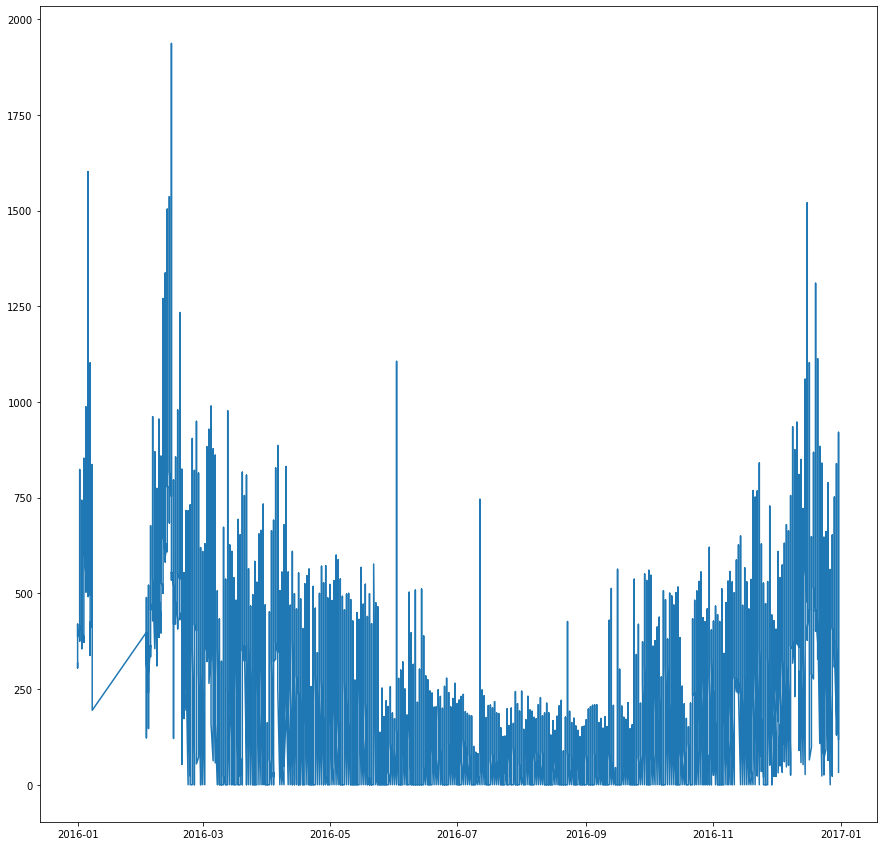

In [49]:
plt.figure(figsize=(15,15))
plt.plot(pd.to_datetime(test["timestamp"]).dt.date, test['meter_reading'])

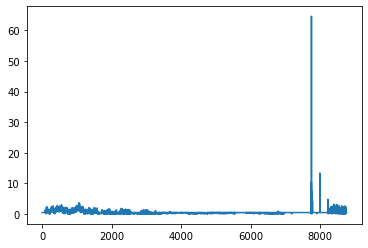

In [21]:
z = np.abs(stats.zscore(test['meter_reading']))
pd.Series(z).describe()
plt.plot(z)

In [22]:
test = test[(np.abs(stats.zscore(test['meter_reading'])) < 20)]

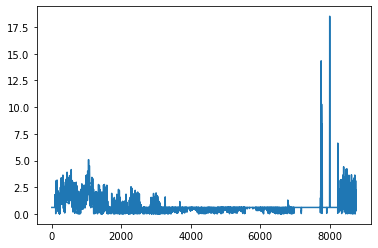

In [23]:
z = np.abs(stats.zscore(test['meter_reading']))
pd.Series(z).describe()
plt.plot(z)

In [235]:
### Testing Prophet ###
#test_ts = test[['timestamp', 'meter_reading']]
#test_ts['timestamp'] = pd.to_datetime(test_ts["timestamp"])
#test_ts = test_ts.set_index('timestamp')
#test_ts = test_ts.meter_reading.fillna(test_ts.meter_reading.rolling(969,min_periods=1).mean())
#test_ts.isnull().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [ ]:
#test_ts.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

In [172]:
################ Manual check of singe buildings ##################
df_train_elec = df_train[(df_train['site_id'] == 14) & (df_train['meter'] == 1)] 
df_train_elec_test = df_train_elec[df_train_elec['building_id'] == 753]

In [173]:
df_train_elec.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,is_constant_meter
3022992,7,1,2016-02-29 09:00:00,1857.260,0,Education,121074,1989.000,nan,13.300,9.635,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022993,9,1,2016-02-29 09:00:00,590.945,0,Office,27000,2010.000,nan,13.300,9.347,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022994,13,1,2016-02-29 09:00:00,1224.100,0,Education,99380,2000.000,nan,13.300,7.035,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022995,14,1,2016-02-29 09:00:00,1435.150,0,Education,86250,2013.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022996,15,1,2016-02-29 09:00:00,422.104,0,Office,83957,1974.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan


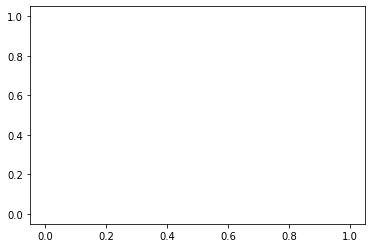

In [148]:
#z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
#plt.plot(z)

In [149]:
#df_train_elec['building_id'].unique()

array([  7,   9,  13,  14,  15,  29,  30,  31,  43,  50,  55,  60,  75,
        76,  78,  82,  91,  92,  95,  96,  97, 103,  28,  98])

In [150]:
#test = df_train_elec.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
#df_train_elec_test[(np.abs(stats.zscore(df_train_elec_test['meter_reading'])) < 5)]
#test.shape

In [203]:
#df_train_elec = df_train[(df_train['meter'] ==  1) & (df_train['building_id'] == 7)] 

In [152]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')]

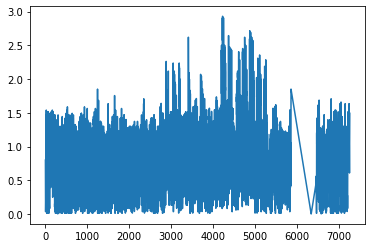

In [154]:
#z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
#plt.plot(z)

In [155]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-05-20 17:00:00')].head(30) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


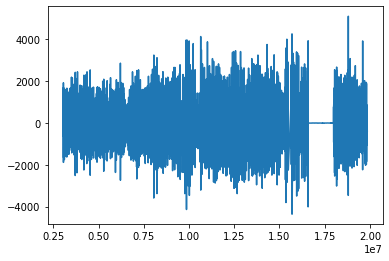

In [204]:
#plt.plot(df_train_elec['meter_reading'].rolling(2).apply(roll_diff))

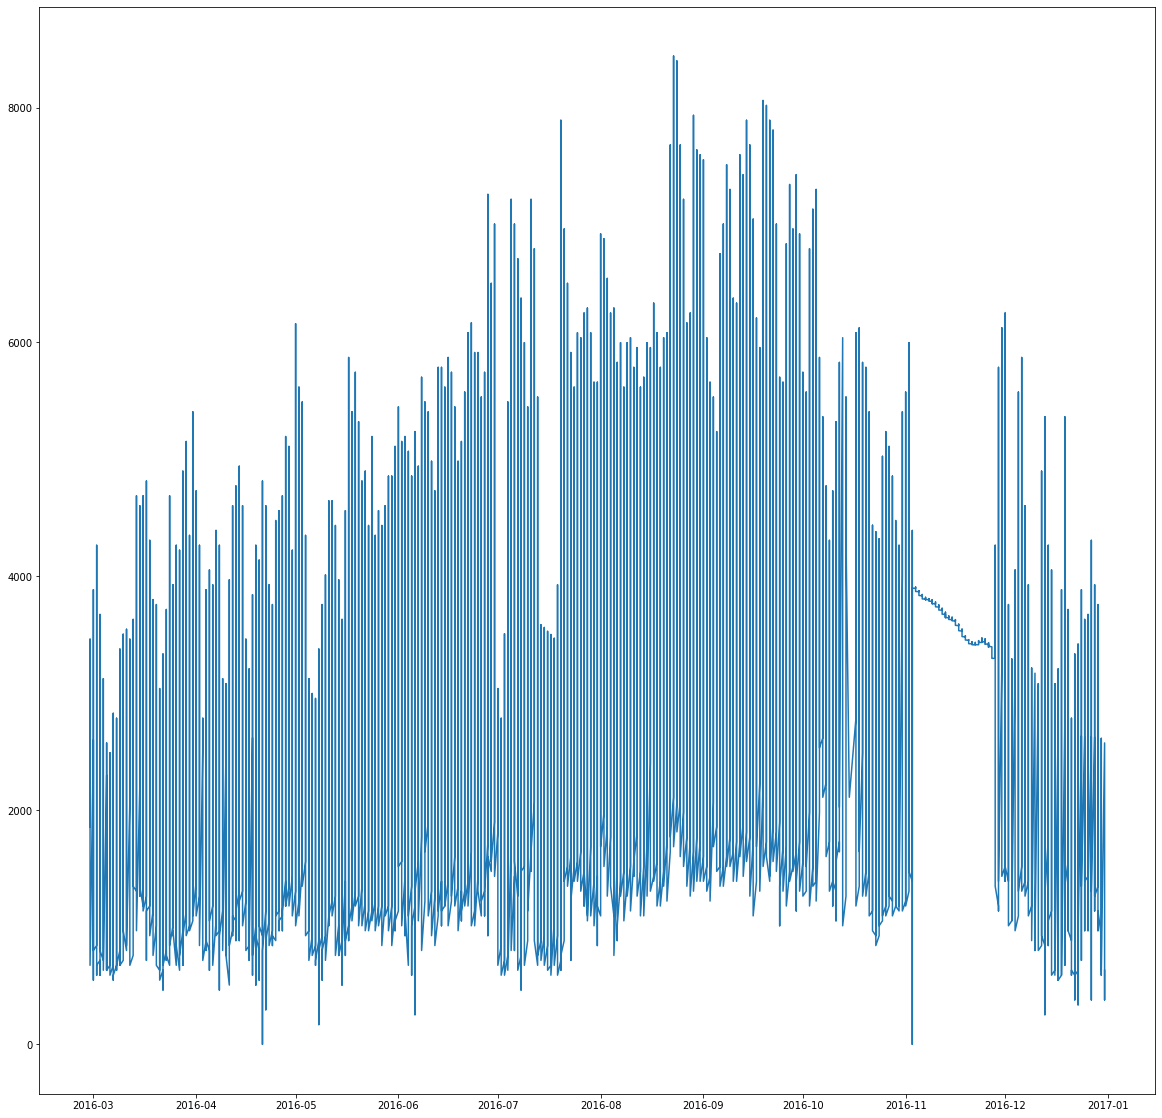

In [205]:
plt.figure(figsize=(20,20))
plt.plot(pd.to_datetime(df_train_elec["timestamp"]).dt.date, df_train_elec['meter_reading'])

In [879]:
#df_train = df_train[df_train["meter_reading"] != 0.0]

In [880]:
#encode_cols = ["primary_use"]

In [881]:
#data = dp.encode_categorical(df_train, df_test, encode_cols) 

In [882]:
#mb = mc.modelBuilder('regression', 'LGBM')

In [883]:
#data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                             target = 'meter_reading', rem_cols = ['timestamp'], 
#                             useVarImp = False, varimp_threshold = 100)

In [884]:
#data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)

In [ ]:
#data['Y'] = np.log(data['Y'])

In [102]:
#data['Y'][data['Y'] == -inf] = 0

In [ ]:
#data['Y'].describe()

In [51]:
def rmse(y, yhat):
    score = sqrt(mean_squared_error(y, yhat))
    return(score)

In [76]:
# LGBM
params = {
    'boosting_type':'gbdt',
    'n_estimators':300,
    'num_leaves':32, 
    'objective':'regression_l2', 
    'colsample_bytree': 1.0, 
    'learning_rate': 0.05,
    'max_bin':255, 
    'max_depth':9, 
    'metric':'rmse', 
    'min_child_samples':10,
    'min_child_weight':5, 
    'min_split_gain':0.0,
    'random_state':1234,
    'lambda_l2': 1.5,
    'verbose' : 2,
    #'reg_alpha':0.0,
    #'reg_lambda':0.0, 
    #'silent':True, 
    'subsample':1.0
    #,
    #'early_stopping_round' : 100
}

In [10]:
### CatBoost params
params = {
    'iterations':500,
    'learning_rate' : 0.3,
    'depth' : 9,
    'loss_function' : 'RMSE',
    'verbose' : 2,
    'eval_metric': 'RMSE',
}

In [11]:
#gc.collect()

In [12]:
#df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [13]:
#df_train_build.head(20)

In [14]:
#submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                      save_varimp = True, params = params, oversmp = False, cv_shuffle=False)

In [247]:
df_test.dtypes

row_id                  int64
building_id             int64
meter                   int64
timestamp              object
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
IsHoliday             float64
Day                     int64
Hour                    int64
DayOfWeek               int64
dtype: object

In [ ]:
df_train = df_train.drop(['is_constant_meter'], axis = 1)

In [456]:
df_train[df_train['meter_reading'] < 0]['meter_reading'] = 0 

In [ ]:
#### Replace Constants with Prophet ####
df_train_final = pd.read_csv('./df_train_prophet_for_constants.csv', compression = 'gzip')
df_train_prophet = df_train_final[['timestamp', 'building_id', 'meter', 'meter_reading']]
df_train_prophet.columns = ['timestamp', 'building_id', 'meter', 'meter_reading_prophet']
df_train = df_train.merge(df_train_prophet, on = ['timestamp', 'building_id', 'meter'])
df_train.meter_reading.fillna(df_train.meter_reading_prophet, inplace=True)
df_train = df_train.drop(['meter_reading_prophet','is_constant_meter'], axis = 1)

In [55]:
df_train.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid
building_id,1.000,0.208,0.009,0.980,0.084,-0.213,-0.370,-0.317,-0.158,-0.101,0.056,0.085,0.049,0.009,0.001,-0.003,-0.000,-0.000,0.327,0.003,-0.314,0.175,-0.177,-0.326
meter,0.208,1.000,0.018,0.241,0.131,0.021,0.191,-0.007,-0.143,-0.074,0.019,-0.049,-0.024,-0.080,0.001,-0.002,0.000,0.000,-0.091,-0.002,0.018,-0.086,0.083,0.048
meter_reading,0.009,0.018,1.000,0.012,0.025,0.132,0.133,-0.004,0.011,-0.003,-0.000,-0.004,0.000,0.006,-0.001,-0.000,0.001,-0.001,0.001,0.000,-0.005,-0.001,0.001,-0.002
site_id,0.980,0.241,0.012,1.000,0.088,-0.181,-0.357,-0.309,-0.124,-0.127,0.052,0.062,0.051,0.017,0.001,-0.003,-0.000,-0.000,0.280,0.003,-0.295,0.131,-0.135,-0.295
square_feet,0.084,0.131,0.025,0.088,1.000,0.146,0.569,-0.015,-0.003,-0.022,0.039,-0.019,-0.017,-0.034,0.000,-0.001,0.000,0.000,-0.008,-0.004,0.000,-0.005,0.002,-0.017
year_built,-0.213,0.021,0.132,-0.181,0.146,1.000,0.133,0.171,0.084,0.101,-0.023,-0.031,-0.063,-0.049,0.002,0.004,0.000,-0.000,-0.101,-0.006,0.167,-0.003,-0.002,0.063
floor_count,-0.370,0.191,0.133,-0.357,0.569,0.133,1.000,-0.182,-0.211,-0.167,0.145,-0.044,0.073,-0.018,-0.002,-0.002,-0.000,0.001,0.048,0.012,-0.187,-0.114,0.120,-0.080
air_temperature,-0.317,-0.007,-0.004,-0.309,-0.015,0.171,-0.182,1.000,-0.010,0.751,0.017,-0.314,-0.099,-0.086,-0.055,0.026,0.156,-0.006,-0.445,-0.007,0.933,0.096,-0.096,0.509
cloud_coverage,-0.158,-0.143,0.011,-0.124,-0.003,0.084,-0.211,-0.010,1.000,0.064,0.050,-0.113,0.013,0.193,-0.005,0.006,0.040,-0.000,0.101,-0.001,0.005,0.070,-0.077,-0.063
dew_temperature,-0.101,-0.074,-0.003,-0.127,-0.022,0.101,-0.167,0.751,0.064,1.000,0.089,-0.222,-0.174,-0.145,-0.043,0.026,-0.008,-0.005,0.257,0.007,0.609,0.643,-0.643,-0.034


In [77]:
### Per site and meter type ###
perf_dict = {}
final_sub_lst = []
encode_cols = ["primary_use"]
mb = mc.modelBuilder('regression', 'LGBM')
for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(6, 7, 1)):
    print(f'training site_id {i}')
    
    df_train_site = df_train[df_train['site_id'] == i]
    df_test_site = df_test[df_test['site_id'] == i]
    
    for j in df_train_site['meter'].unique():
        
        print(f'training meter {j}')
        df_train_metr = df_train_site[df_train_site['meter'] == j]
        df_test_metr = df_test_site[df_test_site['meter'] == j]

        df_train_metr = df_train_metr[(np.abs(stats.zscore(df_train_metr['meter_reading'])) < 5)]
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[x['meter_reading'] < x['meter_reading'].quantile(0.99)])
        
        data = dp.encode_categorical(df_train_metr, df_test_metr, encode_cols)
        data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
                                 target = 'meter_reading', rem_cols = ['timestamp'], 
                                 useVarImp = False, varimp_threshold = 100)
        data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
        data['Y'] = np.log(data['Y'])
        data['Y'][data['Y'] == -inf] = 0
        submit = mb.run_model(data, n_folds = 3, metric_func = rmse, get_probab = False, 
                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
        submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
        final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

        perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
        final_sub_lst.append(final_submit)
    

training site_id 1.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.25474982393959783
Fold: 1
The valuation metric for the fold 1 is 0.67256397336865
Fold: 2
The valuation metric for the fold 2 is 0.4524829967650696
The average score accross the folds is 0.4599322646911059
training meter 3.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.5092354705375444
Fold: 1
The valuation metric for the fold 1 is 1.7711069912237014
Fold: 2
The valuation metric for the fold 2 is 1.8166209522502057
The average score accross the folds is 1.6989878046704838
training site_id 2.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.47468366033226345
Fold: 1
The valuation metric for the fold 1 is 0.376041626820226
Fold: 2
The valuation metric for the fold 2 is 0.41560908226282306
The average score accross the folds is 0.4221114564717709
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.2719479239967761
Fold: 1
The valuation metric for the fold 1 is 1.0902515042813288
Fold: 2
The valuation metric for the fold 2 is 1.2187936007357751
The average score accross the folds is 1.1936643430046268
training meter 3.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.1819095246110392
Fold: 1
The valuation metric for the fold 1 is 0.7650329100972295
Fold: 2
The valuation metric for the fold 2 is 1.1257452815202538
The average score accross the folds is 1.0242292387428409
training site_id 3.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.5610572719320926
Fold: 1
The valuation metric for the fold 1 is 0.4591582121944036
Fold: 2
The valuation metric for the fold 2 is 0.5411135438124725
The average score accross the folds is 0.5204430093129896
training site_id 4.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.2500138831872594
Fold: 1
The valuation metric for the fold 1 is 0.288180064752829
Fold: 2
The valuation metric for the fold 2 is 0.2678961549247868
The average s

/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.32972562522636106
Fold: 1
The valuation metric for the fold 1 is 0.35642195700382046
Fold: 2
The valuation metric for the fold 2 is 0.3792693835772046
The average score accross the folds is 0.355138988602462
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.751514080451298
Fold: 1
The valuation metric for the fold 1 is 1.3369309657474902
Fold: 2
The valuation metric for the fold 2 is 1.7103094136789234
The average score accross the folds is 1.5995848199592373
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.5332628820191414
Fold: 1
The valuation metric for the fold 1 is 1.645407038195375
Fold: 2
The valuation metric for the fold 2 is 1.806413693626591
The average score accross the folds is 1.6616945379470358
training site_id 7.0
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.153885316104387
Fold: 1
The valuation metric for the fold 1 is 1.5036142429890316
Fold: 2
The valuation metric for the fold 2 is 1.592754004677981
The average score accross the folds is 1.4167511879237997
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.449560193954717
Fold: 1
The valuation metric for the fold 1 is 1.4593020949256696
Fold: 2
The valuation metric for the fold 2 is 1.8032133513671291
The average score accross the folds is 1.5706918800825054
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.14640776298818042
Fold: 1
The valuation metric for the fold 1 is 0.4551573303340379
Fold: 2
The valuation metric for the fold 2 is 0.3923508798717148
The average score accross the folds is 0.3313053243979777
training meter 3.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.3728581003308775
Fold: 1
The valuation metric for the fold 1 is 2.4964764630841723
Fold: 2
The valuation metric for the fold 2 is 2.0560301886078465
The average score accross the folds is 1.9751215840076322
training site_id 8.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.7415719239656767
Fold: 1
The valuation metric for the fold 1 is 0.7012729957456476
Fold: 2
The valuation metric for the fold 2 is 0.6648918552980307
The average score accross the folds is 0.7025789250031185
training site_id 9.0
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.2300260962706238
Fold: 1
The valuation metric for the fold 1 is 1.3121118008339374
Fold: 2
The valuation metric for the fold 2 is 1.3134082419291573
The average score accross the folds is 1.2851820463445727
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.2531152165041266
Fold: 1
The valuation metric for the fold 1 is 1.3215459081212264
Fold: 2
The valuation metric for the fold 2 is 1.19995975517424
The average score accross the folds is 1.2582069599331975
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.2724151550537344
Fold: 1
The valuation metric for the fold 1 is 0.21771758283117906
Fold: 2
The valuation metric for the fold 2 is 0.24878497855263035
The average score accross the folds is 0.2463059054791813
training site_id 10.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.4225452557865572
Fold: 1
The valuation metric for the fold 1 is 0.4085256106259856
Fold: 2
The valuation metric for the fold 2 is 0.49369039526985253
The average score accross the folds is 0.44158708722746515
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.03162801693518
Fold: 1
The valuation metric for the fold 1 is 1.6200641513064158
Fold: 2
The valuation metric for the fold 2 is 1.9094795797940214
The average score accross the folds is 1.8537239160118724
training meter 3.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.092915743866696
Fold: 1
The valuation metric for the fold 1 is 1.91294411568604
Fold: 2
The valuation metric for the fold 2 is 2.185427472215741
The average score accross the folds is 2.0637624439228257
training site_id 11.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.13642764993946804
Fold: 1
The valuation metric for the fold 1 is 0.2141793960423598
Fold: 2
The valuation metric for the fold 2 is 0.19017825275371505
The average score accross the folds is 0.18026176624518098
training meter 3.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.7438044761786717
Fold: 1
The valuation metric for the fold 1 is 1.3259226464475529
Fold: 2
The valuation metric for the fold 2 is 1.18616555775773
The average score accross the folds is 1.0852975601279848
training meter 1.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.44251384546154193
Fold: 1
The valuation metric for the fold 1 is 1.872324379846232
Fold: 2
The valuation metric for the fold 2 is 1.202583669459309
The average score accross the folds is 1.172473964922361
training site_id 12.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.30857827511236485
Fold: 1
The valuation metric for the fold 1 is 0.3395524515385393
Fold: 2
The valuation metric for the fold 2 is 0.31541547883436866
The average score accross the folds is 0.32118206849509096
training site_id 13.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3325417908384117
Fold: 1
The valuation metric for the fold 1 is 0.383368037198958
Fold: 2
The valuation metric for the fold 2 is 0.38918040306318175
The average score accross the folds is 0.3683634103668505
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.1399007047828453
Fold: 1
The valuation metric for the fold 1 is 1.0745400040561062
Fold: 2
The valuation metric for the fold 2 is 1.0629544803598407
The average score accross the folds is 1.0924650630662642
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.2935122681804518
Fold: 1
The valuation metric for the fold 1 is 1.671462745928396
Fold: 2
The valuation metric for the fold 2 is 1.3901375172551291
The average score accross the folds is 1.4517041771213257
training site_id 14.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.30776041415107225
Fold: 1
The valuation metric for the fold 1 is 0.29947800999710633
Fold: 2
The valuation metric for the fold 2 is 0.31990978256250907
The average score accross the folds is 0.30904940223689586
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.8683855692167224
Fold: 1
The valuation metric for the fold 1 is 1.4886296609438885
Fold: 2
The valuation metric for the fold 2 is 1.9498138546075356
The average score accross the folds is 1.768943028256049
training meter 3.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.8301569558642066
Fold: 1
The valuation metric for the fold 1 is 1.6598081448324329
Fold: 2
The valuation metric for the fold 2 is 1.9741247349143818
The average score accross the folds is 1.8213632785370069
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.3683862953479602
Fold: 1
The valuation metric for the fold 1 is 1.4015512772652607
Fold: 2
The valuation metric for the fold 2 is 1.8164909042737498
The average score accross the folds is 1.5288094922956568
training site_id 15.0
training meter 3.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.6572924875481452
Fold: 1
The valuation metric for the fold 1 is 0.7058271624828005
Fold: 2
The valuation metric for the fold 2 is 0.6737917966560568
The average score accross the folds is 0.6789704822290008
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.29017797919677196
Fold: 1
The valuation metric for the fold 1 is 0.30178781080303935
Fold: 2
The valuation metric for the fold 2 is 0.32749071851586053
The average score accross the folds is 0.3064855028385573
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.6080958721899529
Fold: 1
The valuation metric for the fold 1 is 0.6202567790129291
Fold: 2
The valuation metric for the fold 2 is 0.5735445133726085
The average score accross the folds is 0.6006323881918302
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.0864121281568728
Fold: 1
The valuation metric for the fold 1 is 1.2276517666004325
Fold: 2
The valuation metric for the fold 2 is 0.8708860469429568
The average score accross the folds is 1.061649980566754
training site_id 0.0
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.1602348701243326
Fold: 1
The valuation metric for the fold 1 is 1.8000281157419715
Fold: 2
The valuation metric for the fold 2 is 2.376370386913905
The average score accross the folds is 2.1122111242600696
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3336868477984532
Fold: 1
The valuation metric for the fold 1 is 0.2778628429883452
Fold: 2
The valuation metric for the fold 2 is 0.42627005932419787
The average score accross the folds is 0.3459399167036654
training site_id nan


In [ ]:
### Per meter type ###
#perf_dict = {}
#final_sub_lst = []
#encode_cols = ["primary_use"]
#mb = mc.modelBuilder('regression', 'LGBM')
#for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(2)):
#    print(f'training site_id {i}')
#    
#    df_train_site = df_train[df_train['site_id'] == i]
#    df_test_site = df_test[df_test['site_id'] == i]

#    data = dp.encode_categorical(df_train_site, df_test_site, encode_cols)
#    data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                                 target = 'meter_reading', rem_cols = ['timestamp'], 
#                                 useVarImp = False, varimp_threshold = 100)
#    data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
#    data['Y'] = np.log(data['Y'])
#    data['Y'][data['Y'] == -inf] = 0
#    submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
#    submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
#    final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

#    perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
#    final_sub_lst.append(final_submit)
    

In [75]:
np.array(list(perf_dict.values())).mean()

1.0213543551573712

In [62]:
perf_dict

{'site_id: 1.0 and meter: 0.0': 0.4548654469274667,
 'site_id: 1.0 and meter: 3.0': 1.7188251894545392,
 'site_id: 2.0 and meter: 0.0': 0.4342511679387993,
 'site_id: 2.0 and meter: 1.0': 1.1987215209414055,
 'site_id: 2.0 and meter: 3.0': 1.0199216543420002,
 'site_id: 3.0 and meter: 0.0': 0.5309109058639121,
 'site_id: 4.0 and meter: 0.0': 0.2748651925324203,
 'site_id: 5.0 and meter: 0.0': 0.7470767838990806,
 'site_id: 6.0 and meter: 0.0': 0.35578741182328394,
 'site_id: 6.0 and meter: 2.0': 1.600360624317586,
 'site_id: 6.0 and meter: 1.0': 1.6669464018831253,
 'site_id: 7.0 and meter: 1.0': 1.4045694821599148,
 'site_id: 7.0 and meter: 2.0': 1.5700850438498604,
 'site_id: 7.0 and meter: 0.0': 0.3297072378051364,
 'site_id: 7.0 and meter: 3.0': 1.9645921386363456,
 'site_id: 8.0 and meter: 0.0': 0.7042958534539694,
 'site_id: 9.0 and meter: 1.0': 1.295633938468656,
 'site_id: 9.0 and meter: 2.0': 1.2673233022714983,
 'site_id: 9.0 and meter: 0.0': 0.24837885227263076,
 'site_id: 1

In [81]:
with open('rmse_siteid_meter_no_zeros.txt', 'w') as file:
     file.write(json.dumps(perf_dict))

In [82]:
sub = pd.concat(final_sub_lst, axis = 0).reset_index(drop = True)
sub.to_csv("submit_lightgbm_by_site_3fold.csv.gz", index = False, compression='gzip')

In [ ]:
#submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])

In [ ]:
#submit['FinalPrediction']

In [ ]:
#submit

In [ ]:
#final_submit = pd.concat([df_test['row_id'], pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

In [ ]:
#final_submit["meter_reading"].describe()

In [ ]:
#final_submit.to_csv("submit_lightgbm_default.csv.gz", index = False, compression='gzip')

In [ ]:
!kaggle competitions submit -c ashrae-energy-prediction -f submit_lightgbm_by_site_3fold.csv.gz -m "lightgbm 3 folds 9 leaves 32 depth and 300 iterations LR - 0.05, no zeroes, manual removal of some values "